In [1]:
import numpy as np
import glob
import nibabel as nib
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv

## Load MICCAI dataset

In [2]:
def load_miccai(path, num_files_to_load=float('inf'), n_zero_ratio = 0.1, max_num_volumes=float('inf'), max_num_slices=float('inf')): # 
    data_list = glob.glob(nii_path + '/*.nii.gz')[:num_files_to_load]
    data = []
    for file in data_list:
        data_new=np.load(file, allow_pickle =True )
        data_new=data_new.astype('float32')
        num_slcs = min(max_num_slices, data_new.shape[0])
        for j in range(num_slcs): 
            if (float(np.count_nonzero(data_new[j,:,:]))/np.prod(data_new[j,:,:].shape))>=n_zero_ratio:
                data_new[j,:,:] = data_new[j,:,:]/127.5-1.0    
                data.append(data_new[j,:,:])
    return np.array(data)

In [13]:
load_dotenv()
mrnet_path = os.getenv('MRNET_DATA')
train_path = f"{mrnet_path}/train/coronal/"
test_path = f"{mrnet_path}/valid/coronal/"

train_imgs = load_mrnet(train_path, num_files_to_load=2)
test_imgs = load_mrnet(test_path, num_files_to_load=1, max_num_slices=25)

with open(os.path.join('./preprocessed_data/', 'training.pickle'), 'wb') as f:
    pickle.dump(train_imgs, f, protocol=4)
    
with open(os.path.join('./preprocessed_data/', 'testing.pickle'), 'wb') as f:
    pickle.dump(test_imgs, f, protocol=4)

In [14]:
print(train_imgs.shape)
print(test_imgs.shape)

(63, 256, 256)
(25, 256, 256)


## Undersampling K-Space

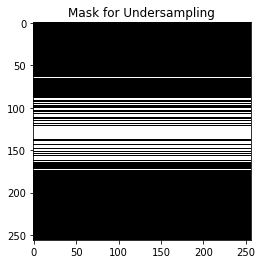

In [15]:
with open('./masks/mask_1dg_a5.pickle', 'rb') as f:
    mask = pickle.load(f)

plt.imshow(mask, cmap='gray')
plt.title('Mask for Undersampling')
plt.show()

In [16]:
def unsample_data(data, mask, accelaration_factor=5):
    uns_data = []
    for i in range(data.shape[0]):
        fourier = np.fft.fft2(data[i,:,:])
        cen_fourier  = np.fft.fftshift(fourier)
        subsam_fourier = np.multiply(cen_fourier,mask) # undersampling in k-space
        uncen_fourier = np.fft.ifftshift(subsam_fourier)
        zro_image = np.fft.ifft2(uncen_fourier) # zero-filled reconstruction
        uns_data.append(zro_image)        
    return np.array(uns_data)

def unsample_data_add_noise(data, mask, noise_ratio, accelaration_factor=5):
    fft_data = []
    uns_data = []
    for i in range(data.shape[0]):
        fourier = np.fft.fft2(data[i,:,:])
        cen_fourier  = np.fft.fftshift(fourier)
        fft_data.append(cen_fourier)
    fft_data = np.array(fft_data)
    fft_std = np.std(fft_data)
    
    nstd = (noise_ratio*fft_std)/np.sqrt(2)
    insh = (fft_data.shape[1],fft_data.shape[2])
    
    for i in range(fft_data.shape[0]):    
        fft_noise=fft_data[i,:,:]+np.random.normal(0,nstd,insh)+1j*np.random.normal(0,nstd,insh) #adding noise
        subsam_fourier = np.multiply(fft_noise,mask) # undersampling in k-space
        uncen_fourier = np.fft.ifftshift(subsam_fourier)
        zro_image = np.fft.ifft2(uncen_fourier) # zero-filled reconstruction
        uns_data.append(zro_image) 
        
    return np.array(uns_data)

In [17]:
def get_uns_imgs(data):
    if data.ndim == 4: # if volumes, choose the first
        data = data[:, :, :, 0]
        
    X1, X2 = train_test_split(data, shuffle=False)
    X2, X3, X4, X5 = np.array_split(X2, 4)

    uns_imgs_1 = unsample_data(X1, mask)
    uns_imgs_2 = unsample_data_add_noise(X2, mask, 0.1) #10% noise-overlapping
    uns_imgs_3 = unsample_data_add_noise(X3, mask, 0.2) #20% noise-overlapping
    uns_imgs_4 = unsample_data_add_noise(X4, mask, 0.1) #10% noise-nonoverlapping
    uns_imgs_5 = unsample_data_add_noise(X5, mask, 0.2) #20% noise-nonoverlapping

    uns_imgs_final = np.concatenate([uns_imgs_1, uns_imgs_2, uns_imgs_3, uns_imgs_4, uns_imgs_5])
#     uns_imgs_final = np.expand_dims(uns_imgs_final, axis = -1)
    return uns_imgs_final

In [18]:
train_data = pickle.load(open('./preprocessed_data/training.pickle', 'rb'))
test_data = pickle.load(open('./preprocessed_data/testing.pickle', 'rb'))
        
uns_train = get_uns_imgs(train_data)
uns_test = get_uns_imgs(test_data)

with open(os.path.join('./preprocessed_data/', 'training_usamp.pickle'), 'wb') as f:
    pickle.dump(uns_train, f, protocol=4)
    
with open(os.path.join('./preprocessed_data/', 'testing_usamp.pickle'), 'wb') as f:
    pickle.dump(uns_test, f, protocol=4)

## Plot example

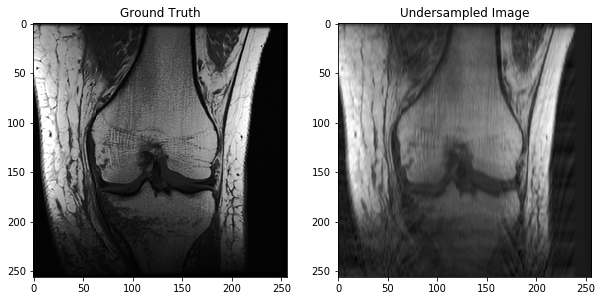

(63, 256, 256)


In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.squeeze(train_data[20]), cmap='gray')
ax[0].set_title('Ground Truth')
ax[1].imshow(np.squeeze(uns_train[20].real), cmap='gray')
ax[1].set_title('Undersampled Image')
plt.show()
print(uns_train.shape)